# Классификация: превышает ли значение  SI > 8
SI (Индекс селективности)

Практическое значение  SI = 8:
представляет разумный баланс между строгостью и практичностью
Выше этого порога значительно увеличиваются шансы на клинический успех лекарства

SI < 2: Общая токсичность (неприемлемо)

SI 2-5: Низкая селективность

SI 5-10: Умеренная селективность

SI > 8-10: Хорошая селективность

In [53]:
!pip install -q catboost
!pip install -q optuna
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_SI.csv')

Saving selected_features_SI.csv to selected_features_SI (1).csv


In [55]:
df.head()

,BalabanJ,MinAbsEStateIndex,BCUT2D_LOGPHI,SMR_VSA5,VSA_EState4,MinPartialCharge,EState_VSA2,BCUT2D_LOGPLOW,MinAbsPartialCharge,Kappa3,...,MolLogP,fr_C_O,FractionCSP3,SMR_VSA7,FpDensityMorgan1,SlogP_VSA4,NumSaturatedHeterocycles,fr_Al_COO,SlogP_VSA10,SI
0,1.164038,0.387225,2.644698,105.750639,4.807589,-0.293526,0.000000,-2.322229,0.038844,2.868737,...,7.1212,0,0.923077,0.00000,0.642857,33.495774,0,0,0.000000,28.125000
1,1.080362,0.533868,2.658342,117.834321,2.153503,-0.313407,0.000000,-2.444817,0.012887,3.027177,...,6.1556,0,1.000000,0.00000,0.607143,33.495774,0,0,0.000000,7.000000
2,1.219066,0.543231,2.679014,117.834321,2.184127,-0.325573,0.000000,-2.565224,0.094802,3.470070,...,7.1292,0,1.000000,0.00000,0.562500,33.495774,0,0,0.000000,0.720000
3,1.120513,0.390603,2.644709,112.171461,4.827852,-0.293526,0.000000,-2.322030,0.038844,3.263848,...,7.5113,0,0.925926,0.00000,0.620690,33.495774,0,0,0.000000,63.235294
4,1.136678,0.270476,2.648473,86.488175,9.071783,-0.257239,10.829981,-2.318893,0.062897,3.345855,...,9.1148,0,0.575758,59.65784,0.600000,33.495774,0,0,11.374773,1.300000


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [57]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BalabanJ                  998 non-null    float64
 1   MinAbsEStateIndex         998 non-null    float64
 2   BCUT2D_LOGPHI             998 non-null    float64
 3   SMR_VSA5                  998 non-null    float64
 4   VSA_EState4               998 non-null    float64
 5   MinPartialCharge          998 non-null    float64
 6   EState_VSA2               998 non-null    float64
 7   BCUT2D_LOGPLOW            998 non-null    float64
 8   MinAbsPartialCharge       998 non-null    float64
 9   Kappa3                    998 non-null    float64
 10  SlogP_VSA3                998 non-null    float64
 11  AvgIpc                    998 non-null    float64
 12  Chi3n                     998 non-null    float64
 13  RingCount                 998 non-null    int64  
 14  BertzCT   

In [59]:
X = df.drop(['SI'], axis=1)
y_continuous = df['SI']
print(f"Размерность данных: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность данных: (998, 25)
Признаки: ['BalabanJ', 'MinAbsEStateIndex', 'BCUT2D_LOGPHI', 'SMR_VSA5', 'VSA_EState4', 'MinPartialCharge', 'EState_VSA2', 'BCUT2D_LOGPLOW', 'MinAbsPartialCharge', 'Kappa3', 'SlogP_VSA3', 'AvgIpc', 'Chi3n', 'RingCount', 'BertzCT', 'NHOHCount', 'MolLogP', 'fr_C_O', 'FractionCSP3', 'SMR_VSA7', 'FpDensityMorgan1', 'SlogP_VSA4', 'NumSaturatedHeterocycles', 'fr_Al_COO', 'SlogP_VSA10']


In [60]:
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, y_continuous,
    test_size=0.2,
    random_state=42
)

print(f"Train: {X_train.shape[0]} образцов")
print(f"Test: {X_test.shape[0]} образцов")

Train: 798 образцов
Test: 200 образцов


Проверим сбалансированность классов

In [61]:
si_threshold = 8.0

y_train = (y_train_cont > si_threshold).astype(int)
y_test = (y_test_cont > si_threshold).astype(int)

# Статистика по исходным значениям SI
print(f"\nСтатистика SI в train:")
print(f"Среднее: {y_train_cont.mean():.2f}")
print(f"Медиана: {y_train_cont.median():.2f}")
print(f"Мин: {y_train_cont.min():.2f}, Макс: {y_train_cont.max():.2f}")

# Распределение классов
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print(f"\nРаспределение классов в TRAIN:")
print(f"SI ≤ 8 (0): {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"SI > 8 (1): {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в TEST:")
print(f"SI ≤ 8 (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"SI > 8 (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")


Статистика SI в train:
Среднее: 43.55
Медиана: 3.86
Мин: 0.01, Макс: 5687.00

Распределение классов в TRAIN:
SI ≤ 8 (0): 518 (64.9%)
SI > 8 (1): 280 (35.1%)

Распределение классов в TEST:
SI ≤ 8 (0): 124 (62.0%)
SI > 8 (1): 76 (38.0%)


 умеренный дисбаланс классов 64.9% / 35.1%, класс "высокоселективных" соединений (SI > 8) естественно

 используем class_weight='balanced'

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
imbalance_ratio = min(train_counts) / max(train_counts)
print(f"Коэффициент сбалансированности train: {imbalance_ratio:.3f}")

Коэффициент сбалансированности train: 0.541


Обучение моделей

In [64]:
# для XGBoost
scale_pos_weight = train_counts[0] / train_counts[1] if len(train_counts) > 1 else 1.0

models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced'
    ),
    'Extra Trees': ExtraTreesClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ),
    'SVM': SVC(
        random_state=42,
        probability=True,
        class_weight='balanced'
    )
}

results = {}
for name, model in models.items():
    print(f"\n--- Обучение {name} ---")

    # Выбираем данные (масштабированные для линейных моделей и SVM)
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    model.fit(X_train_use, y_train)

    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Кросс-валидация на train
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='f1')

    # Метрики на test
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"CV F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



--- Обучение Logistic Regression ---
Accuracy: 0.6450
F1-score: 0.5644
ROC AUC: 0.6909
CV F1-score: 0.5646 ± 0.0295

--- Обучение Random Forest ---
Accuracy: 0.7750
F1-score: 0.6763
ROC AUC: 0.7568
CV F1-score: 0.5539 ± 0.0265

--- Обучение Extra Trees ---
Accuracy: 0.7250
F1-score: 0.6207
ROC AUC: 0.7652
CV F1-score: 0.5915 ± 0.0374

--- Обучение XGBoost ---
Accuracy: 0.7050
F1-score: 0.6093
ROC AUC: 0.7600
CV F1-score: 0.5643 ± 0.0400

--- Обучение SVM ---
Accuracy: 0.6950
F1-score: 0.5850
ROC AUC: 0.7245
CV F1-score: 0.5945 ± 0.0501


Сравнение моделей

In [65]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()]
})

print(results_df.round(4).to_string(index=False))

# Определение лучшей модели
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = results[best_model_name]

print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC AUC: {best_model['roc_auc']:.4f}")
print(f"   Accuracy: {best_model['accuracy']:.4f}")
print(f"   F1-Score: {best_model['f1_score']:.4f}")

              Model  Accuracy  F1-Score  ROC AUC
Logistic Regression     0.645    0.5644   0.6909
      Random Forest     0.775    0.6763   0.7568
        Extra Trees     0.725    0.6207   0.7652
            XGBoost     0.705    0.6093   0.7600
                SVM     0.695    0.5850   0.7245

 ЛУЧШАЯ МОДЕЛЬ: Random Forest
   ROC AUC: 0.7568
   Accuracy: 0.7750
   F1-Score: 0.6763


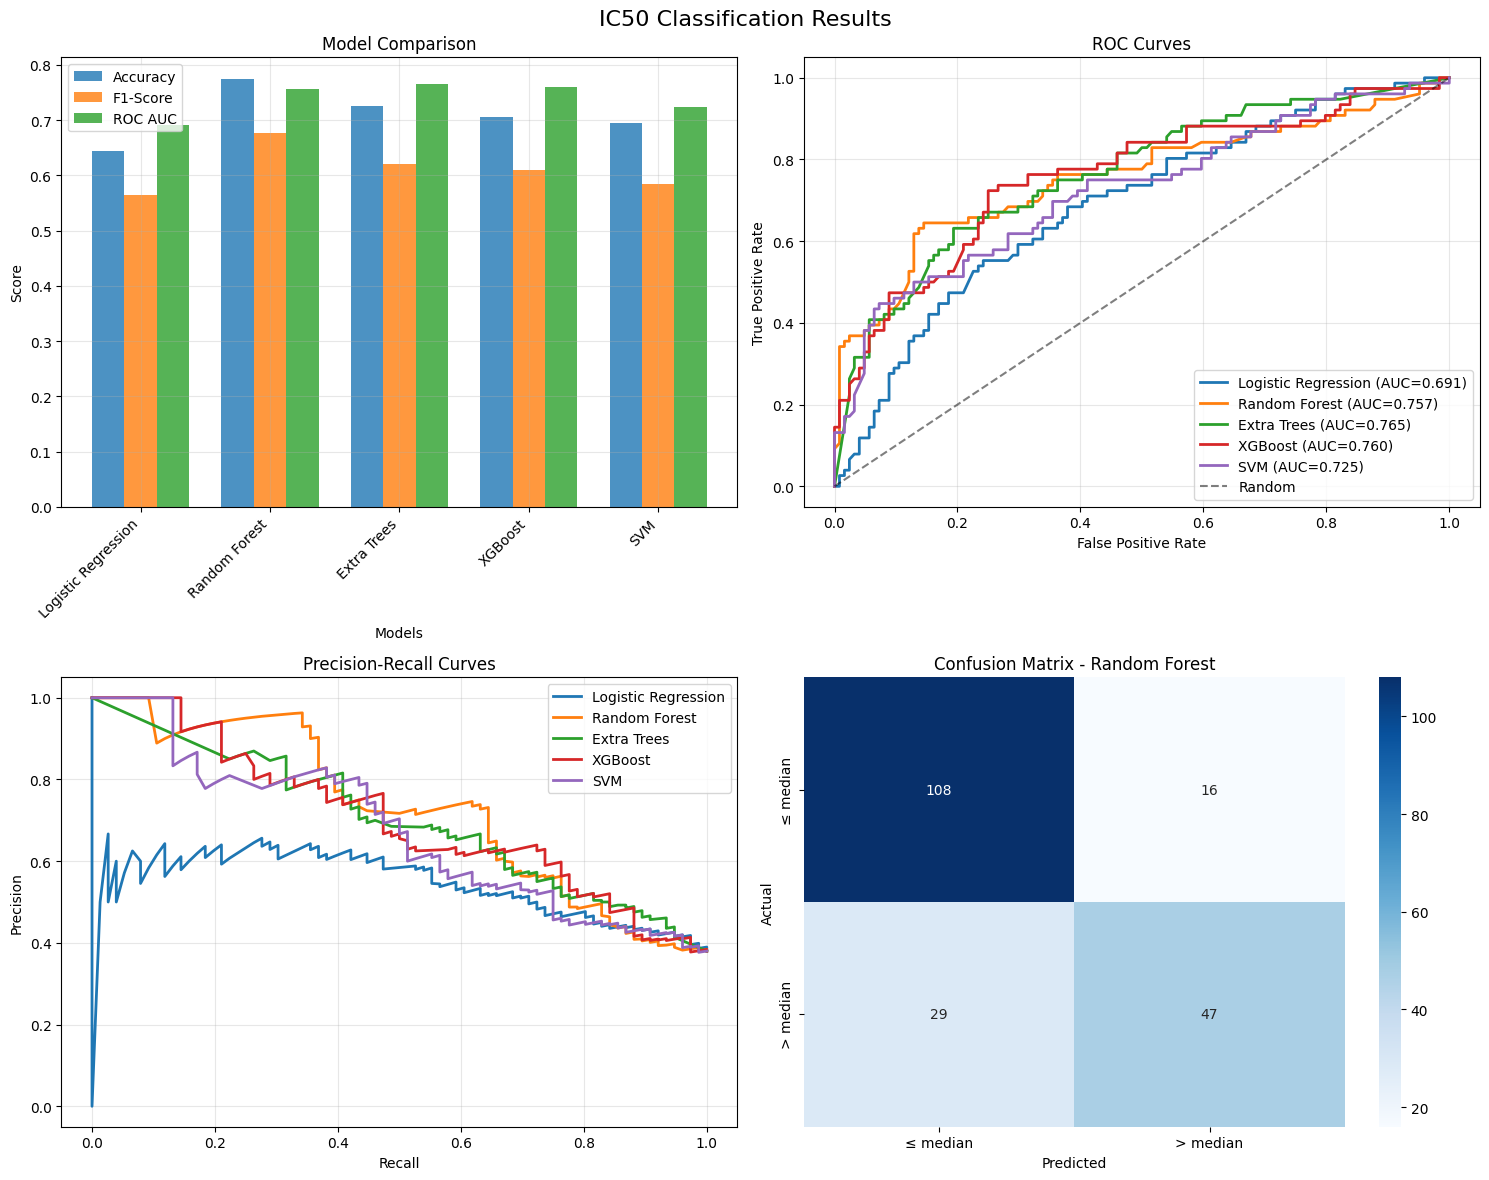

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('IC50 Classification Results', fontsize=16)

# 1. Сравнение моделей
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.25

ax1.bar(x_pos - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x_pos, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width, results_df['ROC AUC'], width, label='ROC AUC', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC кривые
ax2 = axes[0, 1]
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    auc_score = results[name]['roc_auc']
    ax2.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall кривые
ax3 = axes[1, 0]
for name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[name]['y_pred_proba'])
    ax3.plot(recall, precision, label=name, linewidth=2)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix лучшей модели
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['≤ median', '> median'],
            yticklabels=['≤ median', '> median'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [67]:
comparison_data = []
true_0, true_1 = sum(y_test == 0), sum(y_test == 1)

for name in results.keys():
    y_pred = results[name]['y_pred']
    pred_0, pred_1 = sum(y_pred == 0), sum(y_pred == 1)
    correct = sum(y_test == y_pred)

    comparison_data.append({
        'Model': name,
        'True_Class_0 (≤ 8)': true_0,
        'True_Class_1 (> 8)': true_1,
        'Pred_Class_0 (≤ 8)': pred_0,
        'Pred_Class_1 (> 8)': pred_1,
        'Correct': correct,
        'Total': len(y_test),
        'Accuracy': correct/len(y_test)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nСводная таблица предсказаний:")
print(comparison_df.to_string(index=False))


Сводная таблица предсказаний:
              Model  True_Class_0 (≤ 8)  True_Class_1 (> 8)  Pred_Class_0 (≤ 8)  Pred_Class_1 (> 8)  Correct  Total  Accuracy
Logistic Regression                 124                  76                 113                  87      129    200     0.645
      Random Forest                 124                  76                 137                  63      155    200     0.775
        Extra Trees                 124                  76                 131                  69      145    200     0.725
            XGBoost                 124                  76                 125                  75      141    200     0.705
                SVM                 124                  76                 129                  71      139    200     0.695


#Подбор гиперпараметров

In [68]:
# Стратифицированная кросс-валидация
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
hyperparameter_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        },
        'search_type': 'grid'
    },

    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
        'search_type': 'random'  # Слишком много комбинаций для grid
    },

    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
        'search_type': 'random'
    },

    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [1, 1.5, 2]
        },
        'search_type': 'random'
    },

    'SVM': {
        'model': SVC(random_state=42, probability=True, class_weight='balanced'),
        'params': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
        },
        'search_type': 'grid'
    },

}


In [70]:
optimized_results = {}

top_models = ['Logistic Regression',
              'Random Forest',
              'Extra Trees',
              'XGBoost',
              'SVM'
              ]

for model_name in top_models:
    if model_name not in hyperparameter_grids:
        print(f" {model_name} - нет конфигурации")
        continue

    print(f"\n {model_name}...")

    config = hyperparameter_grids[model_name]

    # Выбор данных
    if model_name in ['Logistic Regression', 'SVM', 'Naive Bayes']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Настройка поиска
    if config['search_type'] == 'grid':
        search = GridSearchCV(config['model'], config['params'], cv=cv_strategy, scoring='f1', n_jobs=-1)
    else:
        search = RandomizedSearchCV(config['model'], config['params'], n_iter=50, cv=cv_strategy,
                                  scoring='f1', n_jobs=-1, random_state=42)

    # Поиск лучших параметров
    search.fit(X_train_use, y_train)

    # Лучшая модель
    best_model = search.best_estimator_

    # Тестирование
    y_pred = best_model.predict(X_test_use)
    y_pred_proba = best_model.predict_proba(X_test_use)[:, 1]

    # Метрики
    f1_opt = f1_score(y_test, y_pred)
    accuracy_opt = accuracy_score(y_test, y_pred)
    roc_auc_opt = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    optimized_results[model_name] = {
        'model': best_model,
        'f1_score': f1_opt,
        'accuracy': accuracy_opt,
        'roc_auc': roc_auc_opt,
        'best_params': search.best_params_,
        'time': opt_time
    }

    # Сравнение с базовой моделью
    baseline_f1 = results[model_name]['f1_score']
    improvement = ((f1_opt - baseline_f1) / baseline_f1) * 100

    print(f"   Время: {opt_time:.0f}с | F1: {baseline_f1:.3f} → {f1_opt:.3f} ({improvement:+.1f}%)")



 Logistic Regression...
   Время: 49с | F1: 0.564 → 0.564 (+0.0%)

 Random Forest...
   Время: 49с | F1: 0.676 → 0.640 (-5.4%)

 Extra Trees...
   Время: 49с | F1: 0.621 → 0.627 (+1.0%)

 XGBoost...
   Время: 49с | F1: 0.609 → 0.597 (-2.0%)

 SVM...
   Время: 49с | F1: 0.585 → 0.615 (+5.2%)


При подборе гиперпараметров результат для большинства моделей ухудшился. Это связано с небольшим количеством наблюдений(988), относительно небольшим числом используемых параметров (24), тогда как в исходном датасете их 214. Для улучшения результата: изменить логику отбора признаков, расширить их количество и использовать прием создания новых признаков (Feature Engineering) на основе предоставленных.